In [1]:
import confirm.cloud.clickhouse as ch
# client = ch.connect('wd41_4d_v0')
# ch.list_tables(client)

In [2]:
import confirm.adagrid as ada
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import imprint as ip
import scipy.special
import jax

In [3]:

ip.setup_nb()

db = ada.DuckDBTiles.connect('../../wd41_4d_v47')

2023-03-23 17:11:31,149 - imprint - DEBUG 
Enabling 64-bit floats in JAX.


## Broad table exploration

In [3]:
n_rows_df = pd.DataFrame(
    [(table, db.con.query(f'select count(*) from {table}').fetchone()[0]) for table in ch.all_tables],
    columns=['table', 'count']
).set_index('table')
n_rows_df


,count
table,
results,74353653
tiles,167366042
done,99447410
config,1
logs,28878
reports,9227
null_hypos,2


In [4]:
n_sims = db.con.query('select sum(K) from results').fetchone()[0]
n_retained_sims = db.con.query('select sum(K) from results where active=true').fetchone()[0]
n_sims / 1e12, n_retained_sims / 1e12

(34.91354079232, 32.987104477184)

In [5]:
n_active_tiles = db.con.query(
    "select count(*) from results where active=true"
).fetchone()[0]
n_eligible_tiles = db.con.query(
    "select count(*) from results where eligible=true"
).fetchone()[0]
n_active_tiles, n_eligible_tiles

(67922061, 67922061)

In [ ]:
db.con.query('select K, count(*) as n_tiles from tiles where active=true group by K order by K').df()

,K,n_tiles
0,8192,3398562
1,16384,252287
2,32768,307106
3,65536,325070
4,131072,568781
5,262144,830712
6,524288,62239543


In [6]:
volume_sql = (
    str(2 ** db.dimension())
    + "*"
    + ("*".join([f"radii{d}" for d in range(db.dimension())]))
)

db.con.execute(f'create index if not exists volume_idx2 on results (active, ({volume_sql}))')

In [7]:
smallest_tile = db.con.query(f'select * from results where active=true order by {volume_sql} limit 1').df()
smallest_tile

FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

,id,active,parent_id,theta0,theta1,theta2,theta3,radii0,radii1,radii2,radii3,null_truth0,null_truth1,K,step_id,packet_id,creator_id,creation_time,processor_id,processing_time,eligible,grid_cost,impossible,orderer,alpha0,idx,twb_max_lams,twb_mean_lams,twb_min_lams,lams,B_lams0,B_lams1,B_lams2,B_lams3,B_lams4,B_lams5,B_lams6,B_lams7,B_lams8,B_lams9,B_lams10,B_lams11,B_lams12,B_lams13,B_lams14,B_lams15,B_lams16,B_lams17,B_lams18,B_lams19,...,twb_lams0,twb_lams1,twb_lams2,twb_lams3,twb_lams4,twb_lams5,twb_lams6,twb_lams7,twb_lams8,twb_lams9,twb_lams10,twb_lams11,twb_lams12,twb_lams13,twb_lams14,twb_lams15,twb_lams16,twb_lams17,twb_lams18,twb_lams19,twb_lams20,twb_lams21,twb_lams22,twb_lams23,twb_lams24,twb_lams25,twb_lams26,twb_lams27,twb_lams28,twb_lams29,twb_lams30,twb_lams31,twb_lams32,twb_lams33,twb_lams34,twb_lams35,twb_lams36,twb_lams37,twb_lams38,twb_lams39,twb_lams40,twb_lams41,twb_lams42,twb_lams43,twb_lams44,twb_lams45,twb_lams46,twb_lams47,twb_lams48,twb_lams49
0,4738573164966468825,True,4736452000878125878,0.203125,0.184375,0.221875,0.296875,0.009375,0.009375,0.009375,0.009375,True,False,524288,99,6,1,1.679568e+09,2,1.679568e+09,True,0.005458,False,0.019809,0.019542,10244,0.02122,0.020022,0.019809,0.0199,0.020268,0.019842,0.019909,0.019809,0.019916,0.019857,0.019904,0.0199,0.020546,0.019814,0.019871,0.019871,0.019885,0.019842,0.019904,0.0199,0.019899,0.019971,0.019885,0.019832,...,0.020255,0.019852,0.020841,0.019885,0.019842,0.019975,0.020133,0.019895,0.019885,0.019871,0.019919,0.020024,0.019895,0.01989,0.019809,0.019909,0.02122,0.019814,0.020202,0.019842,0.020527,0.0199,0.020334,0.019955,0.019895,0.021121,0.019885,0.019857,0.019904,0.0199,0.019904,0.019871,0.019904,0.01989,0.019857,0.019895,0.019895,0.019871,0.020296,0.0199,0.019994,0.019857,0.020215,0.019895,0.019904,0.019842,0.019909,0.019857,0.020247,0.019842


In [8]:
largest_tile = db.con.query(f'select * from results where active=true order by {volume_sql} desc limit 1').df()
largest_tile

FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

,id,active,parent_id,theta0,theta1,theta2,theta3,radii0,radii1,radii2,radii3,null_truth0,null_truth1,K,step_id,packet_id,creator_id,creation_time,processor_id,processing_time,eligible,grid_cost,impossible,orderer,alpha0,idx,twb_max_lams,twb_mean_lams,twb_min_lams,lams,B_lams0,B_lams1,B_lams2,B_lams3,B_lams4,B_lams5,B_lams6,B_lams7,B_lams8,B_lams9,B_lams10,B_lams11,B_lams12,B_lams13,B_lams14,B_lams15,B_lams16,B_lams17,B_lams18,B_lams19,...,twb_lams0,twb_lams1,twb_lams2,twb_lams3,twb_lams4,twb_lams5,twb_lams6,twb_lams7,twb_lams8,twb_lams9,twb_lams10,twb_lams11,twb_lams12,twb_lams13,twb_lams14,twb_lams15,twb_lams16,twb_lams17,twb_lams18,twb_lams19,twb_lams20,twb_lams21,twb_lams22,twb_lams23,twb_lams24,twb_lams25,twb_lams26,twb_lams27,twb_lams28,twb_lams29,twb_lams30,twb_lams31,twb_lams32,twb_lams33,twb_lams34,twb_lams35,twb_lams36,twb_lams37,twb_lams38,twb_lams39,twb_lams40,twb_lams41,twb_lams42,twb_lams43,twb_lams44,twb_lams45,twb_lams46,twb_lams47,twb_lams48,twb_lams49
0,4736009241289484841,True,4736009172569877824,-1.3625,-1.3625,-1.2125,-1.1375,0.0375,0.0375,0.0375,0.0375,True,False,32768,6,19,1,1.679531e+09,2,1.679531e+09,True,0.014579,False,0.009361,0.010421,340,0.012828,0.010617,0.009361,0.010409,0.010153,0.011168,0.010669,0.010409,0.010716,0.009751,0.010357,0.009477,0.008958,0.010925,0.009612,0.010506,0.010104,0.009923,0.010425,0.011168,0.010357,0.010627,0.011168,0.010616,...,0.010716,0.011315,0.01147,0.009923,0.010925,0.010122,0.009612,0.011254,0.010627,0.011876,0.010716,0.010472,0.010875,0.010353,0.010985,0.009923,0.010311,0.011315,0.010627,0.010409,0.009361,0.009361,0.010104,0.010875,0.010195,0.010153,0.010174,0.010122,0.010195,0.009923,0.010925,0.010425,0.012828,0.010506,0.010357,0.010859,0.011315,0.010859,0.010716,0.011254,0.010122,0.010875,0.011029,0.010875,0.011581,0.010925,0.010104,0.010195,0.010666,0.010153


In [5]:
lamss_tile = db.con.query('select * from results where active=true order by lams limit 1').df()
lamss_tile

FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

,id,active,parent_id,theta0,theta1,theta2,theta3,radii0,radii1,radii2,radii3,null_truth0,null_truth1,K,step_id,packet_id,creator_id,creation_time,processor_id,processing_time,eligible,grid_cost,impossible,orderer,alpha0,idx,twb_max_lams,twb_mean_lams,twb_min_lams,lams,B_lams0,B_lams1,B_lams2,B_lams3,B_lams4,B_lams5,B_lams6,B_lams7,B_lams8,B_lams9,B_lams10,B_lams11,B_lams12,B_lams13,B_lams14,B_lams15,B_lams16,B_lams17,B_lams18,B_lams19,...,twb_lams0,twb_lams1,twb_lams2,twb_lams3,twb_lams4,twb_lams5,twb_lams6,twb_lams7,twb_lams8,twb_lams9,twb_lams10,twb_lams11,twb_lams12,twb_lams13,twb_lams14,twb_lams15,twb_lams16,twb_lams17,twb_lams18,twb_lams19,twb_lams20,twb_lams21,twb_lams22,twb_lams23,twb_lams24,twb_lams25,twb_lams26,twb_lams27,twb_lams28,twb_lams29,twb_lams30,twb_lams31,twb_lams32,twb_lams33,twb_lams34,twb_lams35,twb_lams36,twb_lams37,twb_lams38,twb_lams39,twb_lams40,twb_lams41,twb_lams42,twb_lams43,twb_lams44,twb_lams45,twb_lams46,twb_lams47,twb_lams48,twb_lams49
0,4738573714722140517,True,4738573027527360605,-0.4625,-1.5875,-0.6125,0.5125,0.0375,0.0375,0.0375,0.0375,True,True,262144,99,57,1,1.679568e+09,2,1.679568e+09,True,0.015342,False,9.287035e-07,0.009658,2530,0.000001,0.000001,9.287035e-07,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,...,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,9.598268e-07,0.000001,9.556591e-07,9.287035e-07,9.966399e-07,0.000001,0.000001,0.000001,9.464038e-07,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,9.958388e-07,0.000001,9.415849e-07,0.000001,9.514950e-07,0.000001,0.000001,0.000001,0.000001,0.000001,9.740014e-07,0.000001,0.000001


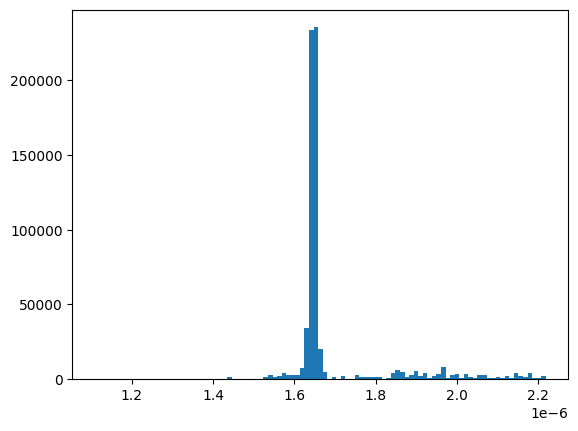

In [ ]:
lams = db.con.query('select lams from results where active=true').df()
lamss = lams['lams'].min()
max_display = lamss * 2
plt.hist(lams['lams'], bins=np.linspace(lamss, max_display, 100))
plt.show()

## Investigating the WD41 problem.

In [6]:
import confirm.models.wd41 as wd41

lamss_potential = lamss_tile.copy()
for d in range(db.dimension()):
    lamss_potential[f"radii{d}"] = 1e-7
cal_df = ip.calibrate(
    wd41.WD41,
    g=ip.Grid(lamss_potential, 1),
    model_kwargs={"ignore_intersection": True, "dtype": np.float64},
)

In [7]:
lamss_potential

,id,active,parent_id,theta0,theta1,theta2,theta3,radii0,radii1,radii2,radii3,null_truth0,null_truth1,K,step_id,packet_id,creator_id,creation_time,processor_id,processing_time,eligible,grid_cost,impossible,orderer,alpha0,idx,twb_max_lams,twb_mean_lams,twb_min_lams,lams,B_lams0,B_lams1,B_lams2,B_lams3,B_lams4,B_lams5,B_lams6,B_lams7,B_lams8,B_lams9,B_lams10,B_lams11,B_lams12,B_lams13,B_lams14,B_lams15,B_lams16,B_lams17,B_lams18,B_lams19,...,twb_lams0,twb_lams1,twb_lams2,twb_lams3,twb_lams4,twb_lams5,twb_lams6,twb_lams7,twb_lams8,twb_lams9,twb_lams10,twb_lams11,twb_lams12,twb_lams13,twb_lams14,twb_lams15,twb_lams16,twb_lams17,twb_lams18,twb_lams19,twb_lams20,twb_lams21,twb_lams22,twb_lams23,twb_lams24,twb_lams25,twb_lams26,twb_lams27,twb_lams28,twb_lams29,twb_lams30,twb_lams31,twb_lams32,twb_lams33,twb_lams34,twb_lams35,twb_lams36,twb_lams37,twb_lams38,twb_lams39,twb_lams40,twb_lams41,twb_lams42,twb_lams43,twb_lams44,twb_lams45,twb_lams46,twb_lams47,twb_lams48,twb_lams49
0,4738573714722140517,True,4738573027527360605,-0.4625,-1.5875,-0.6125,0.5125,1.000000e-07,1.000000e-07,1.000000e-07,1.000000e-07,True,True,262144,99,57,1,1.679568e+09,2,1.679568e+09,True,0.015342,False,9.287035e-07,0.009658,2530,0.000001,0.000001,9.287035e-07,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,...,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,9.598268e-07,0.000001,9.556591e-07,9.287035e-07,9.966399e-07,0.000001,0.000001,0.000001,9.464038e-07,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,9.958388e-07,0.000001,9.415849e-07,0.000001,9.514950e-07,0.000001,0.000001,0.000001,0.000001,0.000001,9.740014e-07,0.000001,0.000001


In [8]:
debug_df = pd.concat(
    (
        lamss_potential[
            [f"theta{d}" for d in range(db.dimension())]
            + [f"radii{d}" for d in range(db.dimension())]
        ],
        cal_df,
    ),
    axis=1,
)
for d in range(db.dimension()):
    name = ['p_{hr+, c}', 'p_{hr+, t}', 'p_{tnbc, c}', 'p_{tnbc, t}'][d]
    debug_df[name] = scipy.special.expit(debug_df[f"theta{d}"])
debug_df.drop(columns=[f"theta{d}" for d in range(db.dimension())], inplace=True)
debug_df

,radii0,radii1,radii2,radii3,lams,alpha0,idx,K,"p_{hr+, c}","p_{hr+, t}","p_{tnbc, c}","p_{tnbc, t}"
0,1.000000e-07,1.000000e-07,1.000000e-07,1.000000e-07,0.000027,0.025,6552,262144,0.386393,0.169736,0.351489,0.625392


In [62]:
model = wd41.WD41(0, 10000, ignore_intersection=True)
g_explore = ip.cartesian_grid([-0.6, -1.5875, -0.6, 0.5125], [-0.4, -1.5875, -0.4, 0.5125], n=[10, 1, 10, 1], null_hypos=model.null_hypos)
cal_df = ip.calibrate(wd41.WD41, g=g_explore, model_kwargs={"ignore_intersection": True, "dtype": np.float64})
cal_df = pd.concat((g_explore.df, cal_df), axis=1)

In [63]:
cal_df['lams'].min()

0.023835260382475913

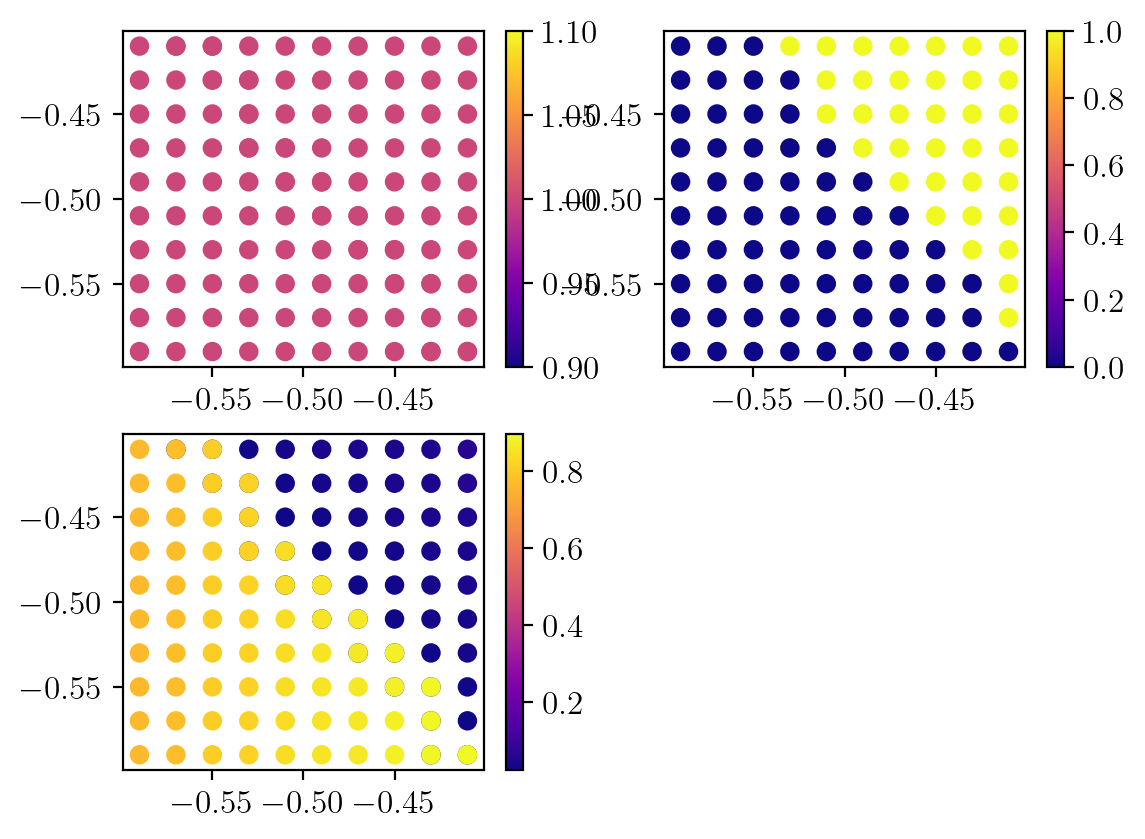

In [64]:
plt.subplot(2,2,1)
plt.scatter(cal_df['theta0'], cal_df['theta2'], c=cal_df['null_truth0'])
plt.colorbar()
plt.subplot(2,2,2)
plt.scatter(cal_df['theta0'], cal_df['theta2'], c=cal_df['null_truth1'])
plt.colorbar()
plt.subplot(2,2,3)
plt.scatter(cal_df['theta0'], cal_df['theta2'], c=cal_df['lams'])
plt.colorbar()
plt.show()

In [65]:
p = scipy.special.expit(g_explore.get_theta()[40])
sim_vmap = jax.vmap(model.sim, in_axes=(0, None, None, None, None, None))
stats = sim_vmap(model.unifs, *p, True)
# print(np.percentile(stats, 99))
# plt.plot(np.sort(stats[0]))
# plt.show()

In [66]:
bad_idx = stats['full_stat'].argmin()
model.sim(model.unifs[bad_idx], *p, True)

{'hypotnbc_live': Array(False, dtype=bool),
 'hypofull_live': Array(True, dtype=bool),
 'hyptnbc_zstat': Array(0.57977104, dtype=float32),
 'hypfull_zstat': Array(3.5796573, dtype=float32),
 'tnbc_stat': Array(0.2810345, dtype=float32),
 'full_stat': Array(0.00017202, dtype=float32),
 'ztnbc_stage1': Array(0., dtype=float32),
 'ztnbc_stage2': Array(0.81992006, dtype=float32),
 'zfull_stage1': Array(1.7075366, dtype=float32),
 'zfull_stage2': Array(3.3548632, dtype=float32)}

In [67]:
(
    phattnbccontrol,
    phattnbctreat,
    phathrpluscontrol,
    phathrplustreat,
) = model.sample_all_arms(model.unifs[bad_idx][model.n_first_stage :], *p)


TypeError: WD41.sample_all_arms() missing 2 required positional arguments: 'n_tnbc_per_arm' and 'n_hrplus_per_arm'

In [59]:
import jax.numpy as jnp
totally_pooledaverage = (
    (phattnbctreat + phattnbccontrol) * model.n_tnbc_first_stage_per_arm
    + (phathrplustreat + phathrpluscontrol) * model.n_hrplus_first_stage_per_arm
) / model.n_first_stage
denominatortotallypooled = jnp.sqrt(
    totally_pooledaverage
    * (1 - totally_pooledaverage)
    # * (1 / (model.n_first_stage))
    * ((1 / (2 * model.n_tnbc_first_stage_per_arm)) + (1 / (2 * model.n_hrplus_first_stage_per_arm)))
)
tnbc_effect = phattnbctreat - phattnbccontrol
hrplus_effect = phathrplustreat - phathrpluscontrol
zfull = (
    (tnbc_effect * model.n_tnbc_first_stage_total)
    + (hrplus_effect * model.n_hrplus_first_stage_total)
) / (denominatortotallypooled * model.n_first_stage)

In [60]:
zfull

Array(3.3438177, dtype=float32)

In [36]:
((tnbc_effect * model.n_tnbc_first_stage_total)
+ (hrplus_effect * model.n_hrplus_first_stage_total)) / model.n_first_stage

Array(0.25675675, dtype=float32)

In [37]:
denominatortotallypooled

Array(0.13346963, dtype=float64)

In [30]:
phattnbccontrol, phattnbctreat, phathrpluscontrol, phathrplustreat

(Array(0.175, dtype=float32),
 Array(0.25, dtype=float32),
 Array(0.20588236, dtype=float32),
 Array(0.6764706, dtype=float32))

In [46]:
def sample(unifs, p):
    return jnp.sum(unifs < p, dtype=model.dtype)

def sample_all_arms(
    self, unifs, pcontrol_tnbc, ptreat_tnbc, pcontrol_hrplus, ptreat_hrplus
):
    unifs_tnbc = unifs[: self.n_tnbc_second_stage_total]
    unifs_tnbc_control = unifs_tnbc[: self.n_tnbc_second_stage_per_arm]
    unifs_tnbc_treat = unifs_tnbc[self.n_tnbc_second_stage_per_arm :]
    unifs_hrplus = unifs[self.n_tnbc_second_stage_total :]
    unifs_hrplus_control = unifs_hrplus[: self.n_hrplus_second_stage_per_arm]
    unifs_hrplus_treat = unifs_hrplus[self.n_hrplus_second_stage_per_arm :]

    ytnbccontrol = sample(unifs_tnbc_control, pcontrol_tnbc)
    ytnbctreat = sample(unifs_tnbc_treat, ptreat_tnbc)
    yhrpluscontrol = sample(unifs_hrplus_control, pcontrol_hrplus)
    yhrplustreat = sample(unifs_hrplus_treat, ptreat_hrplus)
    return ytnbccontrol, ytnbctreat, yhrpluscontrol, yhrplustreat

In [47]:
(
    ytnbccontrol,
    ytnbctreat,
    yhrpluscontrol,
    yhrplustreat,
) = sample_all_arms(model, model.unifs[bad_idx][model.n_first_stage :], *p)

In [50]:
(
    ytnbccontrol,
    ytnbctreat,
    yhrpluscontrol,
    yhrplustreat,
)

(Array(7., dtype=float32),
 Array(10., dtype=float32),
 Array(7., dtype=float32),
 Array(23., dtype=float32))

In [58]:
ycontrol = ytnbccontrol + yhrpluscontrol
ytreat = ytnbctreat + yhrplustreat
ncontrol = ntreat = (
    model.n_hrplus_first_stage_per_arm + model.n_tnbc_first_stage_per_arm
)
phattreat = ytreat / ntreat
phatcontrol = ycontrol / ncontrol
full_pooledaverage = (phattreat + phatcontrol) * 0.5
denominatorfull = jnp.sqrt(
    full_pooledaverage * (1 - full_pooledaverage) * (2 / ncontrol)
)
zfull = (phattreat - phatcontrol) / denominatorfull
zfull

Array(3.3548632, dtype=float32)

0.737039104104042
6.455732336689835e-06


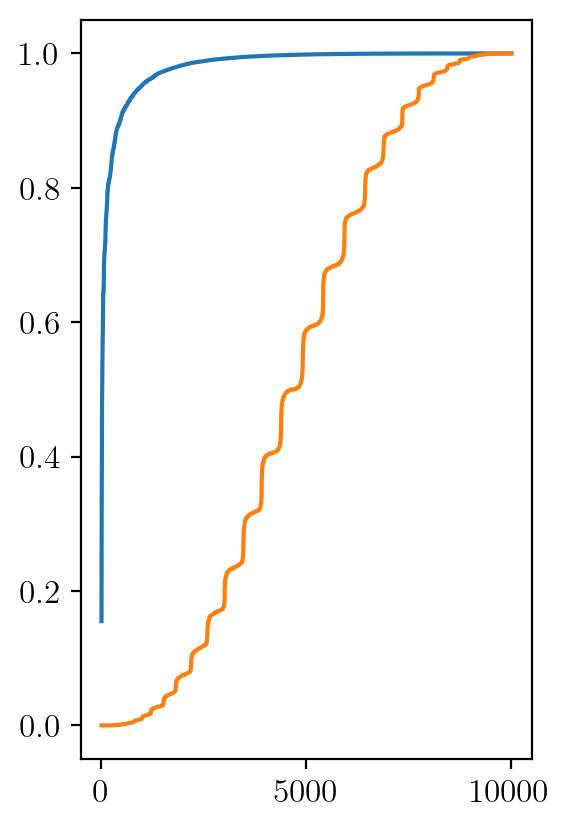

In [112]:
print(np.percentile(stats['tnbc_stat'], 1))
print(np.percentile(stats['full_stat'], 1))
plt.subplot(1,2,1)
plt.plot(np.sort(stats['tnbc_stat']))
plt.subplot(1,2,1)
plt.plot(np.sort(stats['full_stat']))
plt.show()

## Looking at the reports

In [52]:
report_df = db.get_reports()
working_reports = report_df[report_df['status'] == 'WORKING'].dropna(axis=1, how='all')
new_step_reports = report_df[report_df['status'] == 'NEW_STEP'].dropna(axis=1, how='all')

In [55]:
sim_runtime = working_reports['runtime_simulating'].sum()
total_runtime = report_df.iloc[-1]['time'] - report_df.iloc[0]['time']
parallelism = sim_runtime / total_runtime
parallelism, sim_runtime / 3600, total_runtime / 3600

(12.846904770547141, 135.57684610042307, 10.553269329998228)

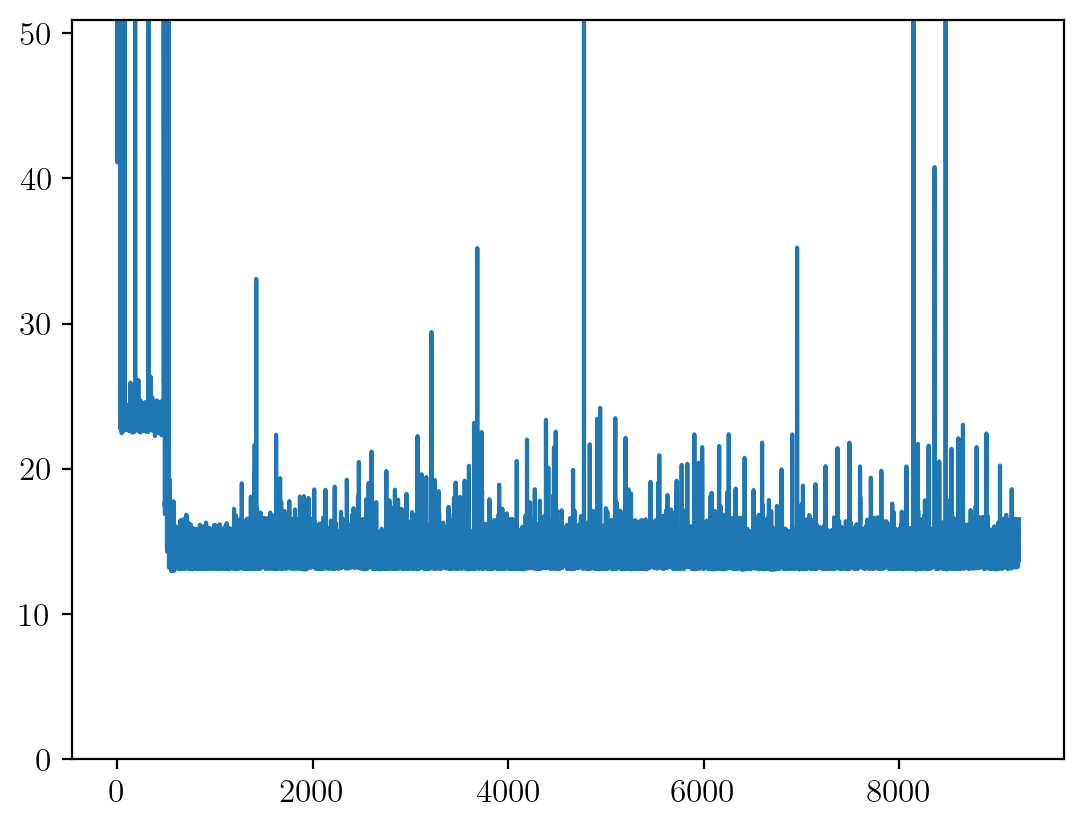

In [56]:
plt.plot(working_reports['runtime_per_sim_ns'])
plt.ylim([0, np.percentile(working_reports['runtime_per_sim_ns'], 99.5)])
plt.show()

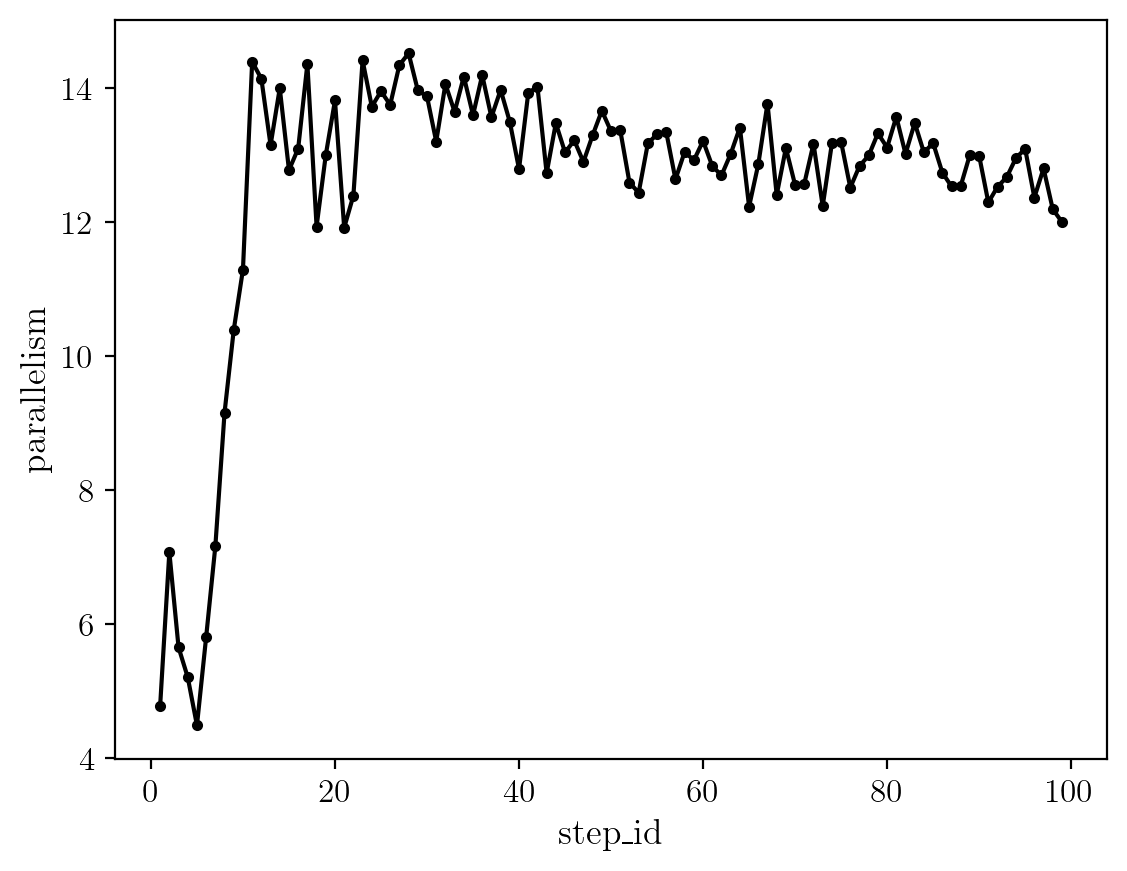

In [57]:
max_working_time = working_reports.groupby('step_id')['time'].max()
total_sim_time = working_reports.groupby('step_id')['runtime_simulating'].sum()
ex_df = new_step_reports[['step_id', 'runtime_total', 'time']].set_index('step_id')
ex_df['max_working_time'] = max_working_time
ex_df['total_sim_time'] = total_sim_time
step_parallelism = ex_df['total_sim_time'] / ((ex_df['max_working_time'] - ex_df['time']) + ex_df['runtime_total'])
plt.plot(step_parallelism, 'k-o', markersize=3)
plt.xlabel('step_id')
plt.ylabel('parallelism')
plt.show()

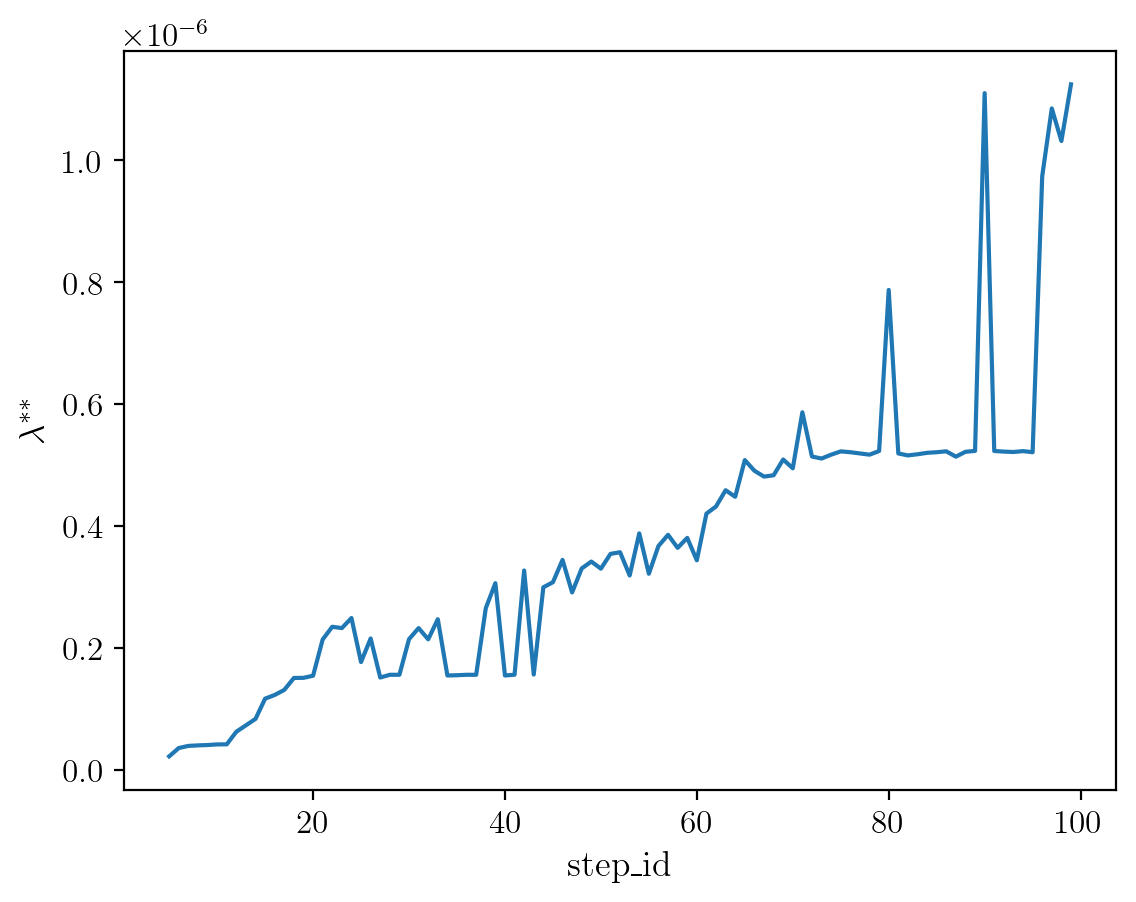

In [58]:
plt.plot(new_step_reports[['step_id', 'lamss']].set_index('step_id'))
plt.xlabel('step_id')
plt.ylabel('$\lambda^{**}$')
plt.show()

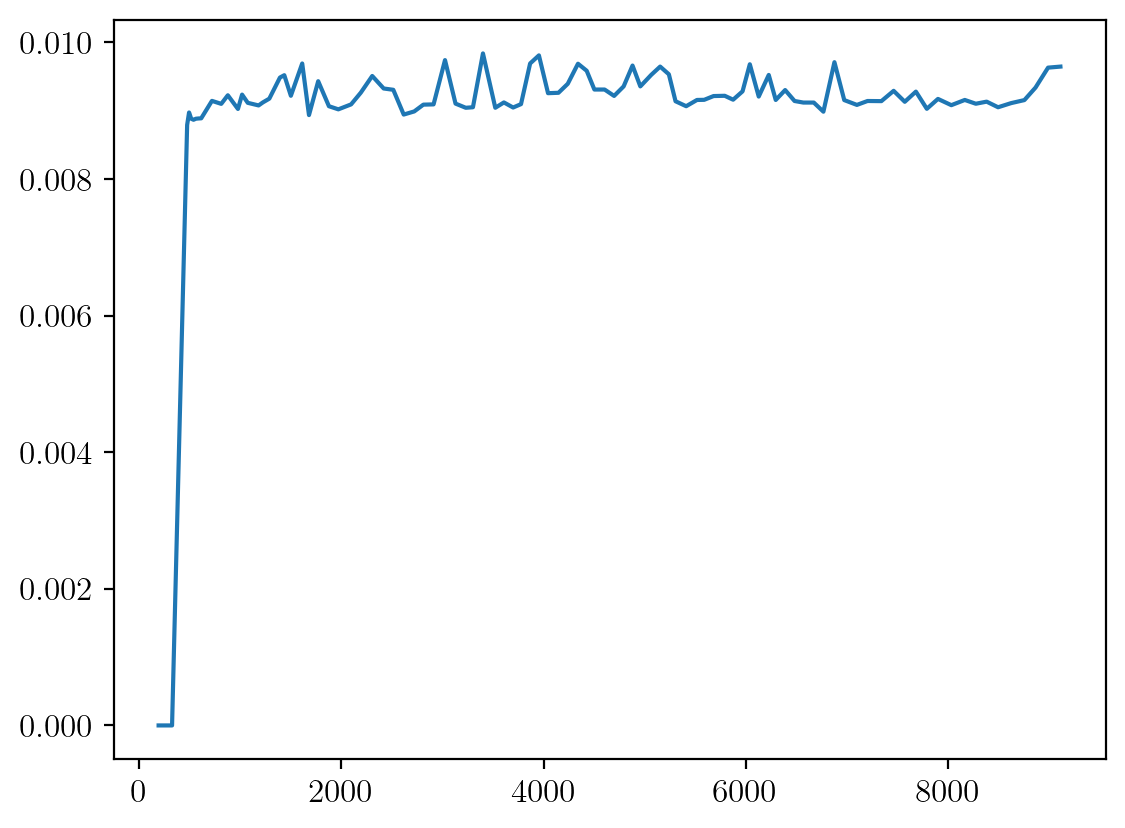

In [60]:
plt.plot(new_step_reports['tie_{k}(lamss)'])
plt.show()

In [43]:
plot_df = db.con.query('''
    select theta0, theta1, theta2, theta3, 
            radii0, radii1, radii2, radii3, 
            alpha0, K, lams, twb_mean_lams, twb_min_lams 
        from results
        where 
            abs(theta0 + 1) < 0.05
            and abs(theta2 + 1) < 0.05
''').df()

In [60]:
import numpy as np
xs = np.linspace(-2, 1, 10)
ys = np.linspace(-2, 1, 10)
counts = np.empty((len(xs), len(ys)))
for i, x in enumerate(xs):
    for j, y in enumerate(ys):
        NN = db.con.query(f'''
            select count(*) 
                from results
                where 
                    active=true
                    and abs(theta0 - {x}) < 0.167
                    and abs(theta2 - {y}) < 0.167
        ''').fetchone()[0]
        counts[i, j] = NN

In [61]:
counts.sum() / 1e6

67.922061

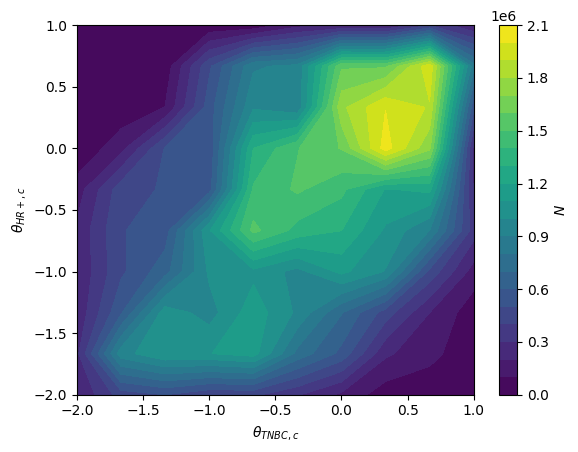

In [63]:
XX, YY = np.meshgrid(xs, ys, indexing='ij')
# plt.scatter(XX.ravel(), YY.ravel(), c=counts.ravel())
plt.contourf(XX, YY, counts, levels=20)
plt.xlabel('$\\theta_{TNBC, c}$')
plt.ylabel('$\\theta_{HR+, c}$')
cbar = plt.colorbar()
cbar.set_label('$N$')
plt.show()

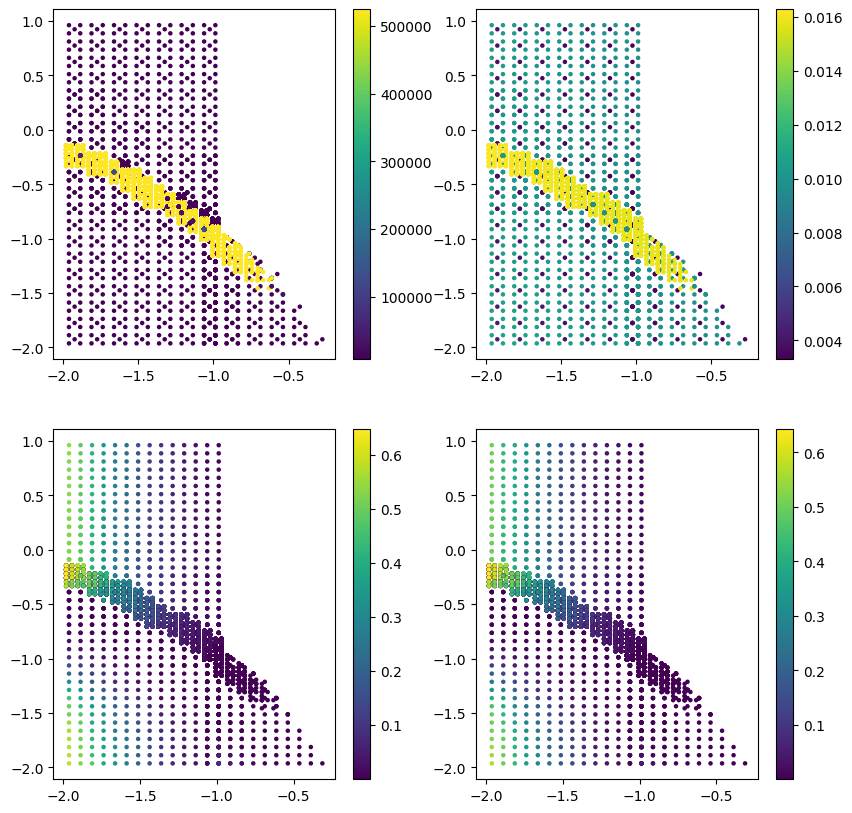

In [47]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.scatter(plot_df['theta1'], plot_df['theta3'], c=plot_df['K'], s=5)
plt.colorbar()
plt.subplot(2, 2, 2)
plt.scatter(plot_df['theta1'], plot_df['theta3'], c=plot_df['alpha0'], s=5)
plt.colorbar()
plt.subplot(2, 2, 3)
plt.scatter(plot_df['theta1'], plot_df['theta3'], c=plot_df['lams'], s=5)
plt.colorbar()
plt.subplot(2, 2, 4)
plt.scatter(plot_df['theta1'], plot_df['theta3'], c=plot_df['twb_min_lams'], s=5)
plt.colorbar()
plt.show()